We have implemented base models for MNIST with keras. How can we implement more sophisticated version?

## Setups

what we need is tensorflow, keras mainly, and a bit of other libraries.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Check if gpu is available here. Are we good?

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Load Data, EDA, and preprocess

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

In [ ]:
x_train.shape, y_train.shape

((54000, 28, 28), (54000,))

In [ ]:
x_val.shape, y_val.shape

((6000, 28, 28), (6000,))

In [ ]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [ ]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

In [ ]:
y_train, y_val, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_val), tf.keras.utils.to_categorical(y_test)

In [ ]:
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

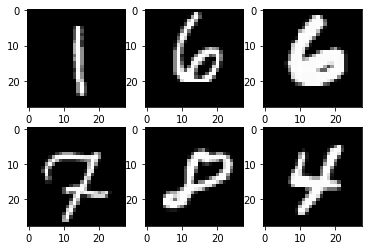

In [ ]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_train[i], cmap = "gray")
plt.show()

## Models

Let's set up some hyperparameters.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
loss = keras.losses.CategoricalCrossentropy()
metrics = ["accuracy"]

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate = 1e-03)

### MLP

Our first apporoach is Multi-layer Perceptron (MLP).

MLP introduces hidden layer with non-linear activation functions.

This combination can generate universal approximator. That is, theortically it can approximate every functions!

In [ ]:
MLL_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = "sigmoid"),
    keras.layers.Dense(128, activation = "sigmoid"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
MLL_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath="./best.ckpt",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
MLL_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

In [ ]:
with tf.device(device_name = device_name):
    hist = MLL_model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, shuffle = True, verbose = 2, validation_data=(x_val, y_val))

Epoch 1/100
844/844 - 9s - loss: 2.3369 - accuracy: 0.0925 - val_loss: 2.2991 - val_accuracy: 0.1048 - 9s/epoch - 10ms/step
Epoch 2/100
844/844 - 6s - loss: 2.2931 - accuracy: 0.1090 - val_loss: 2.2884 - val_accuracy: 0.1097 - 6s/epoch - 7ms/step
Epoch 3/100
844/844 - 4s - loss: 2.2823 - accuracy: 0.1243 - val_loss: 2.2775 - val_accuracy: 0.1630 - 4s/epoch - 5ms/step
Epoch 4/100
844/844 - 4s - loss: 2.2715 - accuracy: 0.1570 - val_loss: 2.2667 - val_accuracy: 0.2445 - 4s/epoch - 4ms/step
Epoch 5/100
844/844 - 3s - loss: 2.2606 - accuracy: 0.2233 - val_loss: 2.2560 - val_accuracy: 0.2190 - 3s/epoch - 3ms/step
Epoch 6/100
844/844 - 3s - loss: 2.2493 - accuracy: 0.2343 - val_loss: 2.2444 - val_accuracy: 0.3153 - 3s/epoch - 3ms/step
Epoch 7/100
844/844 - 3s - loss: 2.2378 - accuracy: 0.3005 - val_loss: 2.2327 - val_accuracy: 0.3302 - 3s/epoch - 3ms/step
Epoch 8/100
844/844 - 3s - loss: 2.2257 - accuracy: 0.3408 - val_loss: 2.2205 - val_accuracy: 0.3440 - 3s/epoch - 3ms/step
Epoch 9/100
844

In [ ]:
with tf.device(device_name = device_name):
    MLL_model.evaluate(x_test, y_test, batch_size = BATCH_SIZE, verbose = 2)

157/157 - 0s - loss: 0.5298 - accuracy: 0.8646 - 423ms/epoch - 3ms/step


### CNN

Convolutional neural network (CNN) performs great on most image tasks. Let's try this. 

In [ ]:
x_train, x_val, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_val, -1), np.expand_dims(x_test, -1)

In [ ]:
x_train.shape, x_val.shape, x_test.shape

((54000, 28, 28, 1), (6000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
CNN_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax"),
])

CNN_model.summary()
CNN_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

with tf.device(device_name = device_name):
    print("training start!")
    hist = CNN_model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, shuffle = True, verbose = 2, validation_data=(x_val, y_val))
    print("evaluation start!")
    CNN_model.evaluate(x_test, y_test, batch_size = BATCH_SIZE, verbose = 2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1384704   
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                      

### Deeper CNN

What if we go deeper with CNN layers?

In [ ]:
Deeper_CNN_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax"),
])

Deeper_CNN_model.summary()
Deeper_CNN_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

with tf.device(device_name = device_name):
    print("training start!")
    hist = Deeper_CNN_model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, shuffle = True, verbose = 2, validation_data=(x_val, y_val))
    print("evaluation start!")
    Deeper_CNN_model.evaluate(x_test, y_test, batch_size = BATCH_SIZE, verbose = 2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 128)       

### Deeper CNN with better Optimizer and Batchnorm

Batchnorm was introduced to stablize the training process. Let's try them! Also, let's try with better optimizer, Adam.

In [ ]:
adam_optimizer = tf.optimizers.Adam(learning_rate=1e-03)

In [ ]:
Deeper_CNN_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding = "same", input_shape=(28, 28, 1)),
    keras.layers.Conv2D(32, (3, 3), padding = "same", input_shape=(28, 28, 1)),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(64, (3, 3), padding = "same"),
    keras.layers.Conv2D(64, (3, 3), padding = "same"),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, (3, 3), padding = "same"),
    keras.layers.Conv2D(128, (3, 3), padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),
    keras.layers.Dense(256),
    keras.layers.Dense(128),
    keras.layers.Dense(10),
    keras.layers.Softmax()
])

Deeper_CNN_model.summary()
Deeper_CNN_model.compile(loss = loss, optimizer = adam_optimizer, metrics = metrics)

with tf.device(device_name = device_name):
    print("training start!")
    hist = Deeper_CNN_model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, shuffle = True, verbose = 2, validation_data=(x_val, y_val))
    print("evaluation start!")
    Deeper_CNN_model.evaluate(x_test, y_test, batch_size = BATCH_SIZE, verbose = 2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)       